<a href="https://colab.research.google.com/github/ab17254/dissertation/blob/main/load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [2]:
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

  0% 0.00/2.14M [00:00<?, ?B/s]
100% 2.14M/2.14M [00:00<00:00, 70.3MB/s]


In [3]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/political_twitter_data.csv  


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
sns.set_style('whitegrid')

In [57]:
pol_df = pd.read_csv('/content/data/political_twitter_data.csv')
# all_df = pd.read_csv('/content/data/data/all_twitter_data.csv')

In [8]:
pol_df['tweet_date'] = pol_df['tweet_date'].map(lambda x: str(x)[:-15])
# all_df['tweet_date'] = all_df['tweet_date'].map(lambda x: str(x)[:-15])

# all_df['tweet_date'] = pd.to_datetime(all_df['tweet_date'])
# all_df = all_df[~(all_df['tweet_date'] < '2017-04-18')]

In [9]:
pol_df['tweet_date'] = pd.to_datetime(pol_df['tweet_date'])

In [6]:
len(pol_df['user_username'].unique())

930

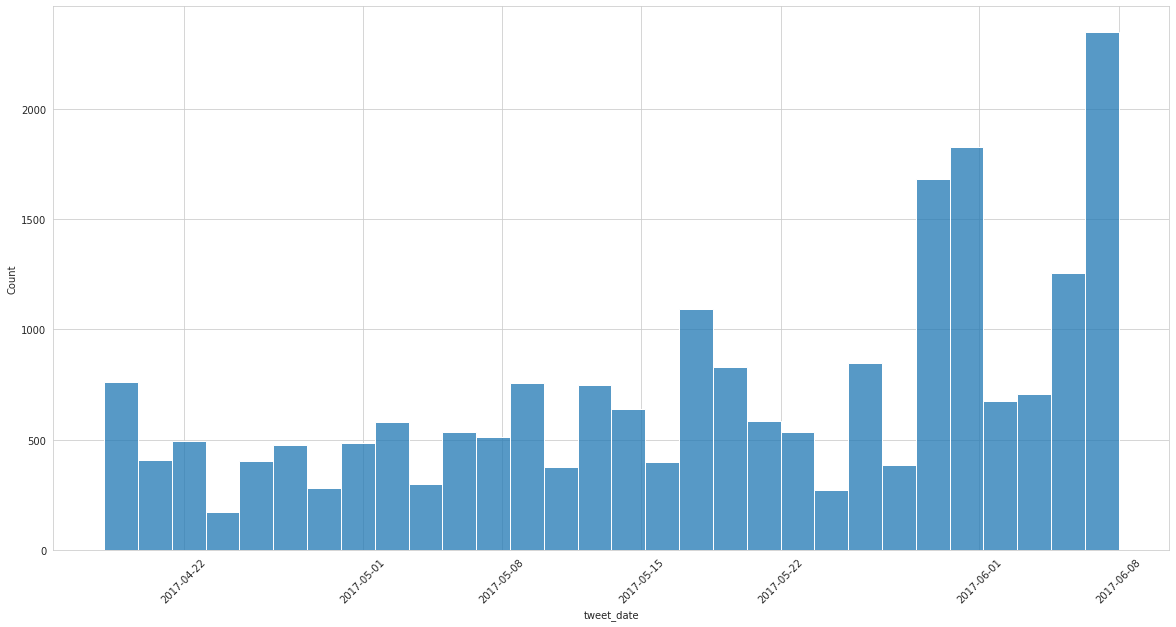

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
g = sns.histplot(data=pol_df, x='tweet_date')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [11]:
pol_df.isnull().sum()

tweet_date                        0
tweet_content                     0
tweet_id                          0
tweet_likes                       0
tweet_replies                     0
tweet_retweets                    0
tweet_quotes                      0
user_username                     0
user_id                           0
user_followers                    0
user_friends                      0
user_statuses                     0
user_verified                     0
user_url                          0
tweet_url                         0
mentioned_users               13765
quotedTweet_id                18654
quotedTweet_content           18654
quotedTweet_username          18654
quotedTweet_userID            18654
quotedTweet_mentionedUsers    20251
dtype: int64

In [4]:
def preprocessing_user(df):

  df['mentioned_users']=df['mentioned_users'].fillna("")
  mentioned_user = []
  for i, user in enumerate(df['mentioned_users']):
    usernames = user.split("username='")
    username_list = []
    for username in usernames:
      username_list.append(re.findall("^(.+?)'", username))
    mentioned_user.append(username_list[1:])
  df = df.drop(columns=['mentioned_users'])
  df['mentioned_users'] = mentioned_user
  df['mentioned_users'] = df['mentioned_users'].apply(lambda x: np.nan if len(x)==0 else x)

  df['quotedTweet_mentionedUsers']=df['quotedTweet_mentionedUsers'].fillna("")
  mentioned_user = []
  for i, user in enumerate(df['quotedTweet_mentionedUsers']):
    usernames = user.split("username='")
    username_list = []
    for username in usernames:
      username_list.append(re.findall("^(.+?)'", username))
    mentioned_user.append(username_list[1:])
  df = df.drop(columns=['quotedTweet_mentionedUsers'])
  df['quotedTweet_mentionedUsers'] = mentioned_user
  df['quotedTweet_mentionedUsers'] = df['quotedTweet_mentionedUsers'].apply(lambda x: np.nan if len(x)==0 else x)

  return df

In [25]:
def preprocessing_tweet(df):

  df['tweet_content'] = df['tweet_content'].str.lower()

  return df

In [28]:
preprocessing_tweet(pol_df)

,tweet_date,tweet_content,tweet_id,tweet_likes,tweet_replies,tweet_retweets,tweet_quotes,user_username,user_id,user_followers,user_friends,user_statuses,user_verified,user_url,tweet_url,mentioned_users,quotedTweet_id,quotedTweet_content,quotedTweet_username,quotedTweet_userID,quotedTweet_mentionedUsers
0,2017-06-08 18:17:30+00:00,"b""please #voteconservative today &amp; let's h...",872880278473199616,10,1,4,0,AdamAfriyie,22031058,16392,860,2357,True,https://twitter.com/AdamAfriyie,https://twitter.com/AdamAfriyie/status/8728802...,"[[User(username='theresa_may', displayname='Th...",NaN,NaN,NaN,NaN,NaN
1,2017-06-08 12:06:45+00:00,b'visited polling stations across the constitu...,872786978256932864,12,1,5,0,AdamAfriyie,22031058,16392,860,2357,True,https://twitter.com/AdamAfriyie,https://twitter.com/AdamAfriyie/status/8727869...,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-05-29 19:31:16+00:00,b'another uplifting visit to slough doorsteps ...,869274966352646145,13,2,5,1,AdamAfriyie,22031058,16392,860,2357,True,https://twitter.com/AdamAfriyie,https://twitter.com/AdamAfriyie/status/8692749...,"[[User(username='MarkVivis', displayname='Mark...",NaN,NaN,NaN,NaN,NaN
3,2017-05-27 18:48:33+00:00,b'the residents of ascot were on the whole rem...,868539438644723712,9,1,3,0,AdamAfriyie,22031058,16392,860,2357,True,https://twitter.com/AdamAfriyie,https://twitter.com/AdamAfriyie/status/8685394...,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-05-16 15:20:47+00:00,b'very happy to sign the #refugeepledge. impor...,864500887246577664,0,0,0,0,AdamBernard_HA,855166968525094914,898,1104,13128,False,https://twitter.com/AdamBernard_HA,https://twitter.com/AdamBernard_HA/status/8645...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21355,2017-04-30 12:48:45+00:00,b'tomorrow @mandoconserv need help in the afte...,858664419269779457,0,0,0,0,LeedsCityTories,1688863044,1564,731,1837,False,https://twitter.com/LeedsCityTories,https://twitter.com/LeedsCityTories/status/858...,"[[User(username='mandoconserv', displayname='M...",NaN,NaN,NaN,NaN,NaN
21356,2017-04-30 12:06:47+00:00,b'thanks to all our activists who were out cam...,858653858284937216,1,0,1,0,LeedsCityTories,1688863044,1564,731,1837,False,https://twitter.com/LeedsCityTories,https://twitter.com/LeedsCityTories/status/858...,"[[User(username='PudseyCons', displayname='Pud...",NaN,NaN,NaN,NaN,NaN
21357,2017-04-27 21:01:14+00:00,b'a great evening with our pm. lovely to see s...,857701195040919552,11,0,4,2,LeedsCityTories,1688863044,1564,731,1837,False,https://twitter.com/LeedsCityTories,https://twitter.com/LeedsCityTories/status/857...,NaN,NaN,NaN,NaN,NaN,NaN
21358,2017-04-20 21:14:02+00:00,b'this sat campaigning for @stuartandrew @pud...,855167700917776384,4,0,1,0,LeedsCityTories,1688863044,1564,731,1837,False,https://twitter.com/LeedsCityTories,https://twitter.com/LeedsCityTories/status/855...,"[[User(username='StuartAndrew', displayname='S...",NaN,NaN,NaN,NaN,NaN


In [17]:
for tweet in pol_df['tweet_content']:
  print(tweet)

Streaming output truncated to the last 5000 lines.
b"great to start today's #ge2017 campaigning by joining @morleyneil and the @morleyclp team for doorknocking in tingley. https://t.co/hntggfniam"
b'labour has challenged @theresa_may to be honest with voters and answer these six questions tonight.\n#askmay #battlefornumber10 https://t.co/fxyqphoffd'
b'tonight 8.30pm, @theresa_may and @jeremycorbyn take questions.\ntweet yours with #askmay #battlefornumber10 \nhttps:// https://t.co/i80zv6k3ap'
b'.@theresa_may needs to understand the anger her #dementiatax proposals have created\n#votelabour #ge2017\nhttps://t.co/xmuwdrogvj'
b"watch: today's #victorialive laid bare the difficulties for carers under the conservatives.\n#votelabour #ge2017\nhttps://t.co/dat695jqvh"
b"'we will transform britain - with an economy upgraded for the many, not the few' \n\n#forthemany #votelabour\n\nhttps://t.co/o3ldnnahuj"
b'join my campaign this week - in the day or evening, on the doors or phones - more info 